# E-commerce website: A/B Testing

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Your goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

In order to achieve this, we use the data obtained from `A/B testing` and perform a `z-test` on it to determine if there is a statistically significant improvement due to implementation of the new page.


## 📕Intializing project

In [1]:
# Importing Dataset from Kaggle

import kagglehub
ab_test = kagglehub.dataset_download('ahmedmohameddawoud/ecommerce-ab-testing')

print('Data source import complete.')

Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sborn

import os

import random

import warnings
warnings.filterwarnings('ignore')

In [3]:
#display the initial dataset
csv_file_path = os.path.join(ab_test, 'ab_test.csv')
df = pd.read_csv(csv_file_path)

print(f"Data Shape: {df.shape}\n\n")
df.head()

Data Shape: (294478, 5)




,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


## 📊 Data cleaning and Transformation

Just like any other Exploratory Data Analysis or Data Analysis problem, it’s critical to ensure the dataset is both clean and logically consistent in `A/B testing`. Even small inconsistencies—like misassigned groups or duplicated users—can bias the results. Therefore, the following data cleaning and transformation checklist needs to be followed while A/B testings.

1. Duplicate Removal
2. Group & Page Validation
3. Missing or Null Values
4. Type Casting & Consistency
5. Balanced Group Check

### 1. Missing or Null Values
- Checked for and removed rows with missing values in critical columns.

In [4]:
# changing column names to align with standard A/B testing critical columns
df.columns = ["user_id", "timestamp", "group", "landing_page", "converted"]

# general info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


All entries contain same **number of non-null values == total entries** in dataset. Therefore, no null values are present.

### 2. Group & Page Validation
- Ensured that:
  - `control` group is always shown the **old landing page**
  - `treatment` group is always shown the **new landing page**
- Dropped rows with mismatches (e.g., control group shown new page) as these violate the test design.

In [5]:
df_mismatch = df[(df["group"] == "treatment") & (df["landing_page"] == "old_page")
               |(df["group"] == "control") & (df["landing_page"] == "new_page")]

n_mismatch = df_mismatch.shape[0]

percent_mismatch = round(n_mismatch / len(df) * 100, 2)
print(f'Number of mismatched rows: {n_mismatch} rows')
print(f'Percent of mismatched rows: {percent_mismatch} %')

Number of mismatched rows: 3893 rows
Percent of mismatched rows: 1.32 %


A/B testing is highly sensitive to mismatches between control group and testing value as this leads to invalidation of the assumptions made for statistical analysis such as Z-test and bias the conversion rates. Therefore, it is important to remove these entries from the dataset for a clean analysis. Additionally, if mismatch % is too high it might be wise to re-run or redesign the experiment.

In [6]:
# Filtering out desired group-landing_page pairs and filtering out mismatches
df2 = df[(df["group"] == "treatment") & (df["landing_page"] == "new_page")
        |(df["group"] == "control") & (df["landing_page"] == "old_page")]

#checking if any mismatches are remaining (counts if checking for treatment-new_page pair yields False)
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 3. Duplicate Removal
- Checked for repeated `user_id` entries which may indicate multiple exposures to the test.
- Retained only the **first occurrence per user** to preserve the integrity of the experiment (one user, one variant).

In [7]:
#drop duplicate rows on user_id
df2 = df2.drop_duplicates("user_id")

len(df2)

290584

### 4. Type Casting & Consistency
- Ensured data types are appropriate (e.g., `converted` as integer, `timestamp` as datetime).
- Sorted data by timestamp for time-series visualization if needed.

In [8]:
# displaying data type of each attribute in the dataframe
df2.dtypes

#displaying first 5 rows for visual check on data type
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


Based on the above visualizations of the dataframe, following our principle we will need to convert the timestamp data into an appropriate data and time format. 

On analyzing the timestamp data the data lies in the range (00:00.0,59:59.9). Based on these observations, it is clear that the time is of the format : <br>
`TIME_FORMAT` = `%M:%S.%f` <t> i.e. minutes:seconds.miliseconds

In [9]:
# Changing data type of timestamp attribute to datetime and sorting
df2['timestamp'] = pd.to_datetime(df2['timestamp'],
                                  format='%M:%S.%f',
                                 errors='coerce')

#checking for error conversions
df2['timestamp'].isna().sum()

0

### 5. Balanced Group Check
- Verified that both `control` and `treatment` groups have comparable sample sizes to maintain statistical power.

In [10]:
cnts = df2['group'].value_counts()
display(cnts)

rel_diff = abs(cnts['control'] - cnts['treatment']) / cnts.sum() * 100
print(f"Relative size difference: {rel_diff:.2f}%")

group
treatment    145310
control      145274
Name: count, dtype: int64

Relative size difference: 0.01%


Since both the groups are pretty comparable in size, we can move forward with statistical analysis of this data as all defined data cleaning and transformation checks have been completed.

## 👀Exploratory Data Analysis

Before performing hypothesis testing,it is a good practice to conduct an initial probabilistic study in order to get a basic idea if there is a visible improvement between the two control groups or not. Therefore, we determine:
1. Overall conversion rate
2. Group-wise conversion rates

Additionally, country-wise data has been provided for each user in the `countries_ab.csv` which we can use to determine if the country of origin has any effect on the overall and group-wise conversion rates.

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290584 non-null  int64         
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  object        
 3   landing_page  290584 non-null  object        
 4   converted     290584 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.3+ MB


In [12]:
# Percent of convergance
# The probability of an individual converting regardless of the page they receive
df2.converted.mean() * 100

11.959708724499627

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290584 non-null  int64         
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  object        
 3   landing_page  290584 non-null  object        
 4   converted     290584 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.3+ MB


In [14]:
df2['landing_page'] = df2['landing_page'].astype(str)

conversion_rate = df2.groupby('group')['converted'].mean() * 100
print(conversion_rate)

group
control      12.038630
treatment    11.880807
Name: converted, dtype: float64


In [15]:
#What is the probability that an individual received the new page?
pd.DataFrame(df2.landing_page.value_counts(normalize = True) * 100)

,proportion
landing_page,
new_page,50.006194
old_page,49.993806


## 📈 Statistical Hypothesis testing

After cleaning and exploring the data, we now formally test whether the new landing page has significantly improved conversion rates compared to the old one.

Since we need to determine if the new page improves the conversion rate, we can set up a **Two-proportion Z-test** which is ideal when measuring **directional improvement or decline**, thus enables us to compare the difference in conversion proportions between the control and treatment groups.  
  
### Setting up hypotheses

We define our hypotheses as follows:

- **Null Hypothesis (H₀)**: There is **no improvement** in conversion rate from the new page.  
  Mathematically, <br>
  $ H_0:p_{\text{new}} - p_{\text{old}} \leq 0$

- **Alternative Hypothesis (H₁)**: The **new page performs better**, i.e., it has a higher conversion rate.  
  $ H_0:p_{\text{old}} - p_{\text{new}} > 0$


In [16]:
# Creating the sampling distribution of difference in means 
means_diff = []
size = df2.shape[0]
for _ in range(10000):
    sample = df2.sample(size, replace = True)
    control_mean = sample[sample["group"] == "control"]["converted"].mean()
    treat_mean = sample[sample["group"] == "treatment"]["converted"].mean()
    means_diff.append(treat_mean - control_mean)

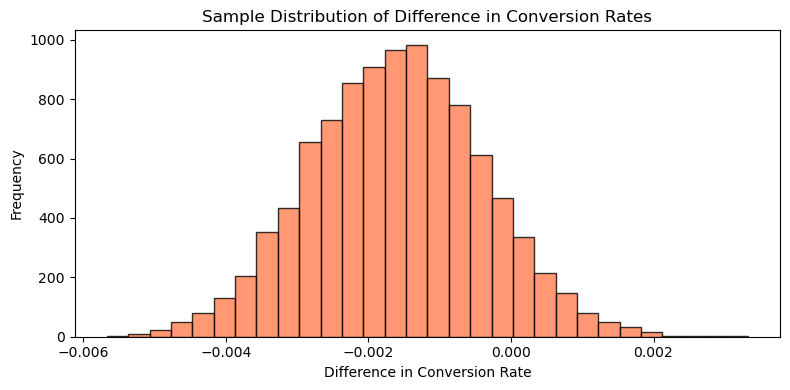

In [17]:
# Plotting the sampling distribution 
plt.figure(figsize=(8, 4), dpi=100)
plt.hist(
    means_diff,
    bins=30,
    color='coral',      # fill color
    edgecolor='black',  # bar borders
    alpha=0.8             # slight transparency
)

plt.title('Sample Distribution of Difference in Conversion Rates')
plt.xlabel('Difference in Conversion Rate')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [18]:
# Simulate distribution under the null hypothesis

means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

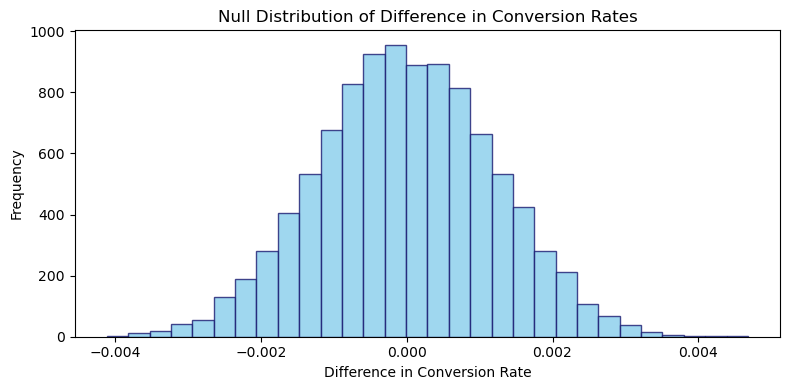

In [19]:
# Plot the null distribution
plt.figure(figsize=(8, 4), dpi=100)
plt.hist(
    null_vals,
    bins=30,
    color='skyblue',      # fill color
    edgecolor='midnightblue',  # bar borders
    alpha=0.8             # slight transparency
)

plt.title('Null Distribution of Difference in Conversion Rates')
plt.xlabel('Difference in Conversion Rate')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


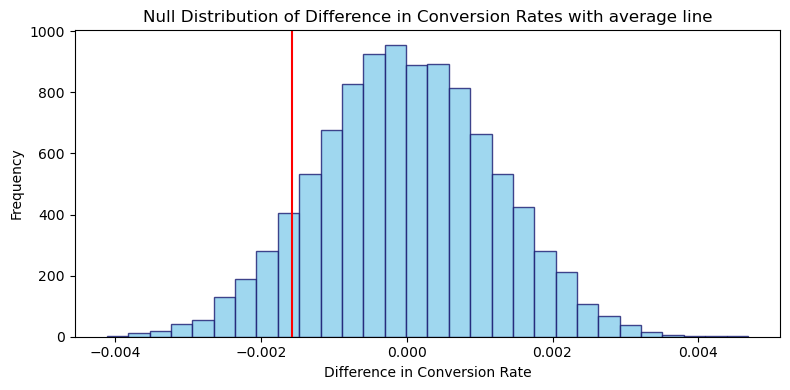

In [20]:
# Plot observed statistic with the null distibution
control_mean = df2[df2["group"] == "control"]["converted"].mean()
treat_mean = df2[df2["group"] == "treatment"]["converted"].mean()
obs_diff = treat_mean - control_mean

plt.figure(figsize=(8, 4), dpi=100)
plt.hist(
    null_vals,
    bins=30,
    color='skyblue',      # fill color
    edgecolor='midnightblue',  # bar borders
    alpha=0.8             # slight transparency
)
plt.axvline(obs_diff, c='red')

plt.title('Null Distribution of Difference in Conversion Rates with average line')
plt.xlabel('Difference in Conversion Rate')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [21]:
# calculating the p value 
(null_vals > obs_diff).mean()

0.9017

### Interpretation

From the z-test, the p-value is obtained to be 0.903. Thus, from the chosen test we obtain p-value ≥ 0.05 and thus, **fail to reject H₀** meaning there's not enough evidence to support the new page’s superiority.


## 🔎 Key insights:

Based on this result, we should **not launch the new page** at this time, as the data does not support a meaningful improvement in conversion. The following insights can be derived from this analysis:
- **No demonstrable improvement:** No demonstrable increase in conversion was observed and the new landing page **does not outperform** the current version.
- **Goal realignment:** A stronger hypothesis is required for before any implementation is taken into consideration. In absence of strong uplift of conversion trends, user feedback, user retention time and heatmaps can be used to quantify the impact of the current redesign by the UX teams and to serve as guidelines for future changes.
- **Segement sensitivity:** With > 290 k observations, statistical power is high; but sub-segments might hide value improvements. Significant improvements in particular segments can justify controlled rollouts as no drop in conversion suggests the new design is at least non‑harmful.

## 📑 Business Decision

Based on these insights, the following business decisions would be recommended:
- **Park the global rollout** of the current redesign; reiterate the design and testing while keeping the control page live.
- **Drill down by segment** to look for micro‑lifts that may merit targeted deployment.
- **Refine hypotheses** test copy clarity, trust badges, or call‑to‑action placement—changes with historically larger effect sizes.
- **Collect qualitative feedback** to understand why the redesign failed to move the needle via user interviews, heatmaps, user retention time, etc.